In [1]:
## Import usual libraries
import cv2, os
import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
#import pandas as pd
import cv2, os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir_data = "drive/MyDrive/Fire_smoke_all_not_fog"
dir_seg = dir_data + "/Masks/"
dir_img = dir_data + "/Images/"

X shape: (1001, 224, 224, 3)
Y shape: (1001, 224, 224)


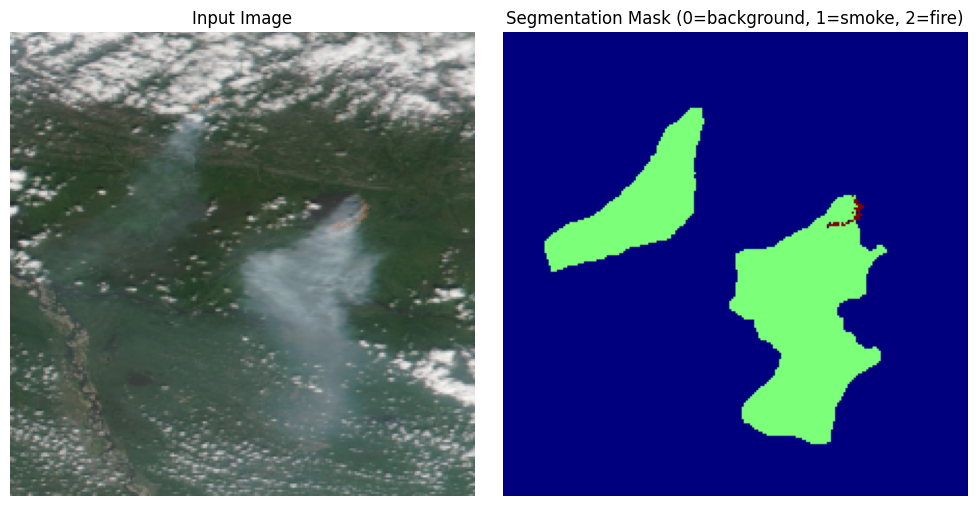

In [ ]:

# Number of classes: 3 (background, smoke, fire)
n_classes = 3  # 0=background, 1=smoke, 2=fire

input_height, input_width = 224, 224
output_height, output_width = 224, 224

def getImageArr(path, width, height):
    """Loads an image from the given path, resizes it, converts from BGR to RGB,
    and normalizes pixel values to [0, 1]."""
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (width, height))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb.astype('float32') / 255.0
    return img_rgb

def getSegmentationArr(path, width, height):
    """Creates a single-channel mask of shape (height, width) with class indices:
      - 0: Background
      - 1: Smoke (white-ish)
      - 2: Fire (red-ish)

    Uses adaptive color thresholding and HSV for robust detection."""
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (width, height))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to HSV for better fire (red) detection
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Fire (red-ish) detection in HSV
    lower_red1 = np.array([0, 100, 50])    # Hue range 0-15
    upper_red1 = np.array([15, 255, 255])
    lower_red2 = np.array([165, 100, 50])  # Hue range 165-180
    upper_red2 = np.array([180, 255, 255])
    red_mask = cv2.inRange(img_hsv, lower_red1, upper_red1) | \
               cv2.inRange(img_hsv, lower_red2, upper_red2)

    # Smoke (white-ish) detection in RGB
    smoke_mask = (img_rgb[:, :, 0] > 180) & \
                 (img_rgb[:, :, 1] > 180) & \
                 (img_rgb[:, :, 2] > 180)

    # Assign class labels: Fire > Smoke > Background
    seg_labels = np.zeros((height, width), dtype=np.uint8)
    seg_labels[red_mask > 0] = 2       # Fire
    seg_labels[smoke_mask] = 1         # Smoke

    # (Optional) Explicitly set background for any very dark pixels
    black_mask = (img_rgb[:, :, 0] < 30) & \
                 (img_rgb[:, :, 1] < 30) & \
                 (img_rgb[:, :, 2] < 30)
    seg_labels[black_mask] = 0

    return seg_labels

images = sorted(os.listdir(dir_img))
segmentations = sorted(os.listdir(dir_seg))
X = []
Y = []

for img_filename, seg_filename in zip(images, segmentations):
    img_path = os.path.join(dir_img, img_filename)
    seg_path = os.path.join(dir_seg, seg_filename)
    X.append(getImageArr(img_path, input_width, input_height))
    Y.append(getSegmentationArr(seg2_path, output_width, output_height) if 'seg2_path' in locals() else getSegmentationArr(seg_path, output_width, output_height))

X = np.array(X)
Y = np.array(Y)  

print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Visualization example
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[0])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Y[0], cmap='jet')
plt.title("Segmentation Mask (0=background, 1=smoke, 2=fire)")
plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# MLP helper function
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Patches layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Patch encoder layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Transformer block
def transformer(x, input_size, patch_size, projection_dim, num_heads, transformer_layers):
    num_patches = (input_size // patch_size) ** 2
    transformer_units = [projection_dim * 2, projection_dim]

    # Create patches
    patches = Patches(patch_size)(x)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    return encoded_patches

# Convolutional block
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Decoder block
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

# Full model
def build_mobilenetv2_unet(input_shape):
    # Input
    inputs = Input(shape=input_shape)

    # Pre-trained MobileNetV2
    encoder = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    # Encoder
    s1 = inputs
    s2 = encoder.get_layer("block_1_expand_relu").output
    s3 = encoder.get_layer("block_3_expand_relu").output

    # Transformer Block
    x_t1 = transformer(s3, input_size=56, patch_size=1, projection_dim=32,
                      num_heads=4, transformer_layers=4)
    encoded_patches = layers.Reshape([56, 56, 32])(x_t1)

    # Decoder
    d1 = decoder_block(encoded_patches, s2, 128)
    d2 = decoder_block(d1, s1, 64)

    # Output (3 classes, softmax activation)
    outputs = Conv2D(3, 1, padding="same", activation="softmax")(d2)

    model = Model(inputs, outputs, name="MobileNetV2_U-Net_ViT")
    return model

if __name__ == "__main__":
    model = build_mobilenetv2_unet((224, 224, 3))
    model.summary()


/tmp/ipython-input-6-791121789.py:95: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  encoder = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2_U-Net_ViT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 742,931 (2.83 MB)

 Trainable params: 740,659 (2.83 MB)

 Non-trainable params: 2,272 (8.88 KB)

In [7]:
class IoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='iou', **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class indices
        y_pred = tf.argmax(y_pred, axis=-1)
        super().update_state(y_true, y_pred, sample_weight)


In [ ]:
import numpy as np
import tensorflow as tf

# ----------------------------------------------------
# 1. Compute class weights from your mask data Y
# ----------------------------------------------------
class_counts = np.bincount(Y.flatten(), minlength=3)  # Force 3 classes (0,1,2)
total = class_counts.sum()

# Handle division by zero if any class has 0 samples
epsilon = 1e-7
class_weights = [total / (len(class_counts) * (count + epsilon)) for count in class_counts]

print("Class counts:", class_counts) 
print("Class weights:", class_weights)  

def weighted_dice_loss(y_true, y_pred, class_weights=[0.8, 30.0, 100.6]):
    """
    Weighted Dice loss to prioritize fire detection.
    class_weights: [background_weight, smoke_weight, fire_weight]
    """
    num_classes = 3
    smooth = 1e-5

    # Cast to int32 (critical fix for one_hot encoding)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, depth=num_classes)  

    y_pred = tf.nn.softmax(y_pred, axis=-1)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])

    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    weights = tf.constant(class_weights, dtype=tf.float32)  # Shape: (3,)

    weighted_dice = dice_per_class * weights
    weighted_dice = tf.reduce_sum(weighted_dice, axis=-1) / tf.reduce_sum(weights)

    return 1 - tf.reduce_mean(weighted_dice)




model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=lambda y_true, y_pred: weighted_dice_loss(y_true, y_pred, class_weights),
    metrics=['accuracy', IoU(num_classes=3)]
)




Class counts: [43841502  6126921   257753]
Class weights: [np.float64(0.3818769408645404), np.float64(2.732540319463299), np.float64(64.95388479148708)]


In [ ]:
print("Y dtype:", Y.dtype)  


Y dtype: uint8


In [14]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (800, 224, 224, 3)
X_test shape: (201, 224, 224, 3)
Y_train shape: (800, 224, 224)
Y_test shape: (201, 224, 224)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_iou',        # Primary metric to monitor
    mode='max',             
    patience=8,              
    min_delta=0.005,         
    restore_best_weights=True 
)

history = model.fit(
    X_train, Y_train,
    batch_size=8,
    epochs=80,
    validation_split=0.2,
    callbacks=[early_stopping] 
)


Epoch 1/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 108s 854ms/step - accuracy: 0.9350 - iou: 0.6977 - loss: 0.9597 - val_accuracy: 0.9293 - val_iou: 0.6881 - val_loss: 0.9625
Epoch 2/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 61s 760ms/step - accuracy: 0.9391 - iou: 0.7111 - loss: 0.9595 - val_accuracy: 0.9291 - val_iou: 0.6868 - val_loss: 0.9625
Epoch 3/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 752ms/step - accuracy: 0.9394 - iou: 0.7160 - loss: 0.9595 - val_accuracy: 0.9271 - val_iou: 0.6843 - val_loss: 0.9623
Epoch 4/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 751ms/step - accuracy: 0.9423 - iou: 0.7128 - loss: 0.9615 - val_accuracy: 0.9288 - val_iou: 0.6884 - val_loss: 0.9623
Epoch 5/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 60s 750ms/step - accuracy: 0.9399 - iou: 0.7114 - loss: 0.9609 - val_accuracy: 0.9325 - val_iou: 0.6913 - val_loss: 0.9623
Epoch 6/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 83s 767ms/step - accuracy: 0.9395 - iou: 0.7199 - loss: 0.9594 - val_accuracy: 0.9312 - val_iou: 0.6818 - val_loss: 0.9623
Epoch 7/80
80/80 ━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


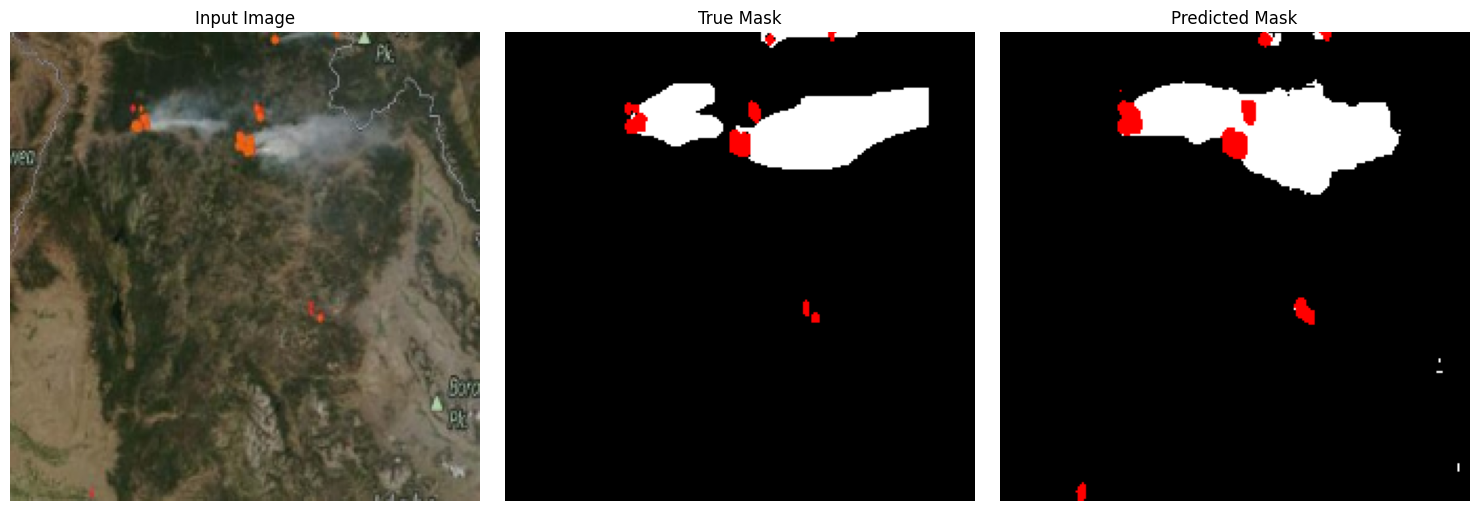

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions for the first image
predictions = model.predict(X_test)

def plot_prediction(index=0):
    image = X_test[index]
    true_mask = Y_test[index]
    pred_mask = np.argmax(predictions[index], axis=-1)  # Convert probabilities to class indices

    # Define color map for classes
    color_map = {
        0: [0, 0, 0],       # Black - Background
        1: [255, 255, 255], # White - Smoke
        2: [255, 0, 0]      # Red - Fire
    }

    # Convert masks to RGB images
    true_mask_rgb = np.zeros((*true_mask.shape, 3), dtype=np.uint8)
    pred_mask_rgb = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)

    for class_idx, color in color_map.items():
        true_mask_rgb[true_mask == class_idx] = color
        pred_mask_rgb[pred_mask == class_idx] = color

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_rgb)
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_rgb)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot the first image prediction
plot_prediction(0)


180


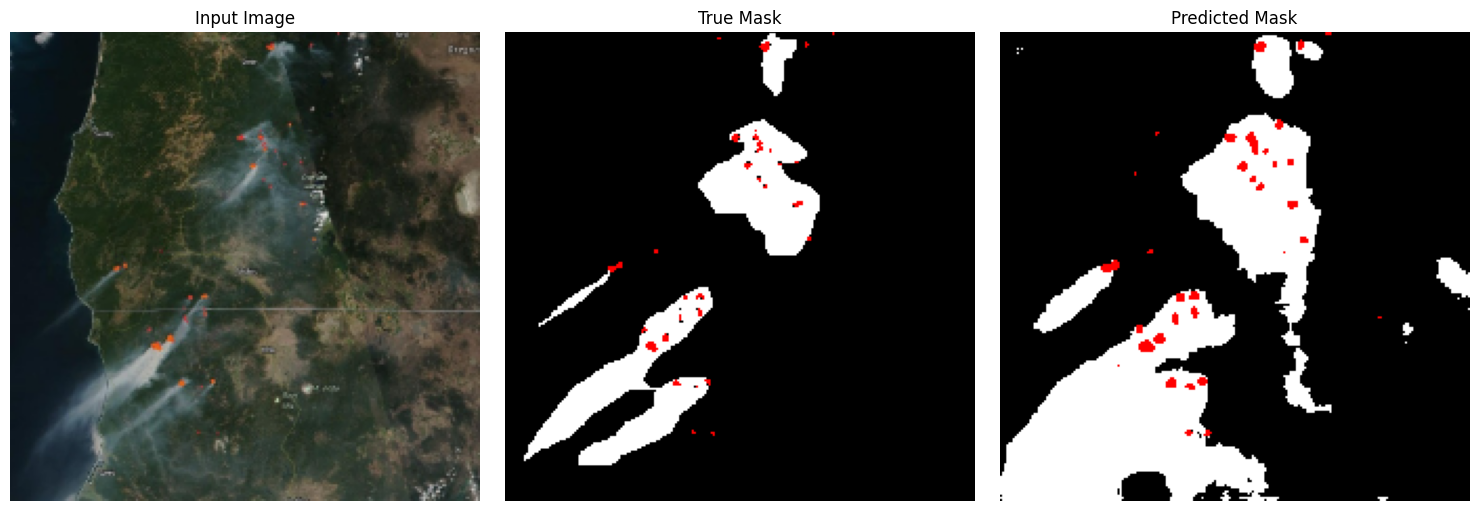

181


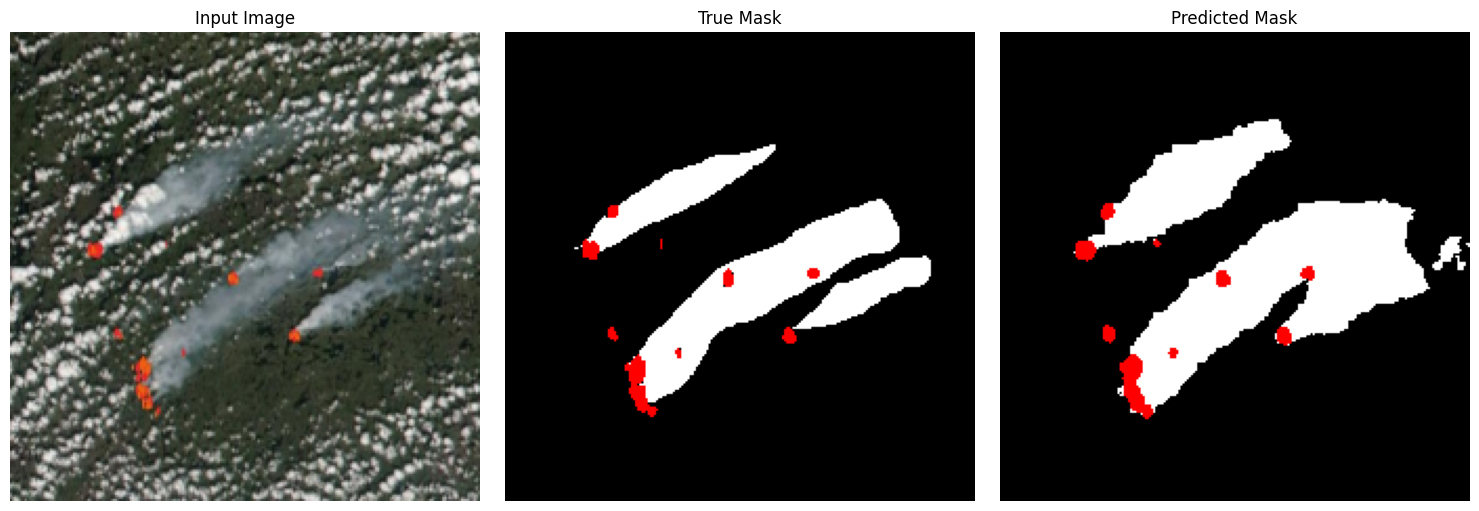

182


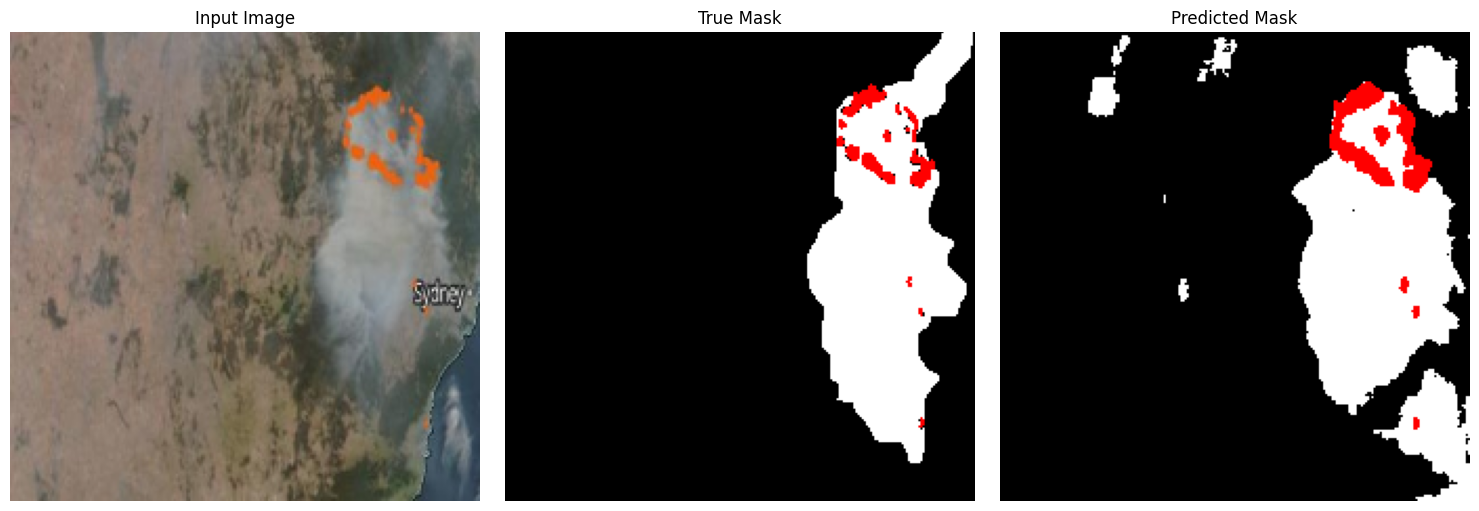

183


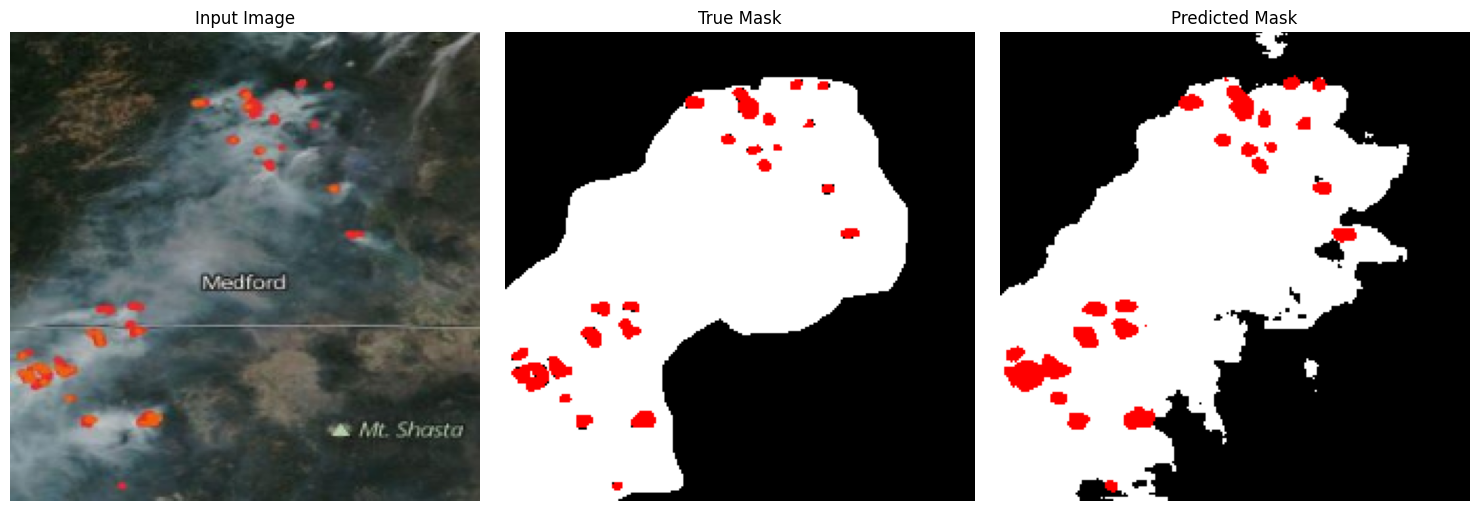

184


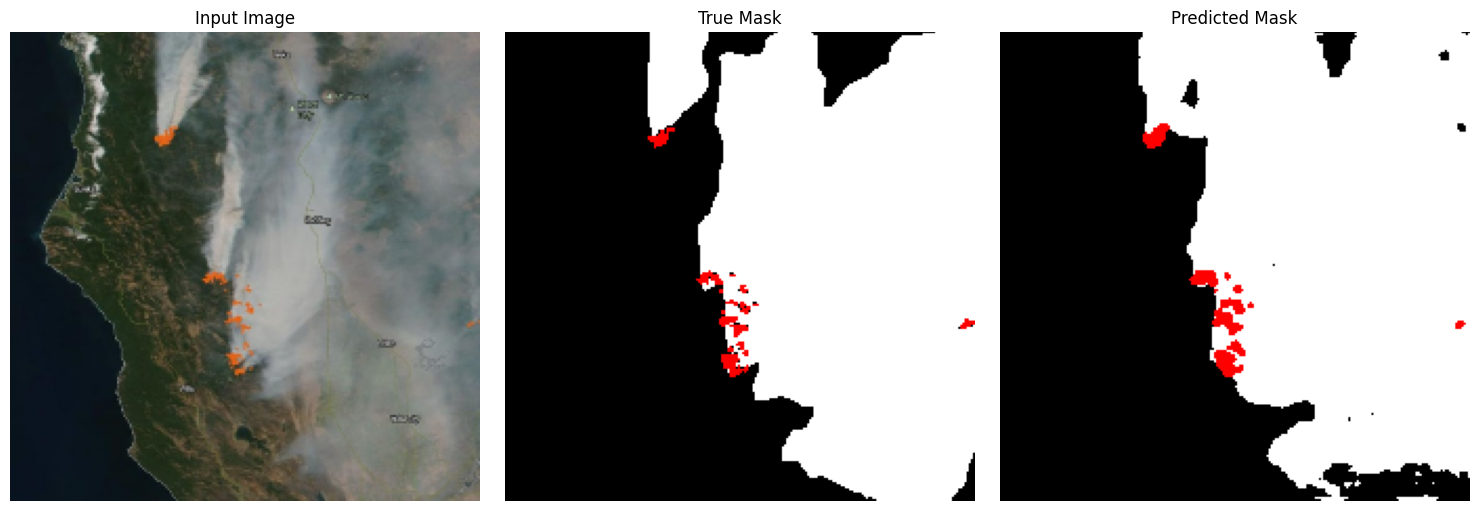

185


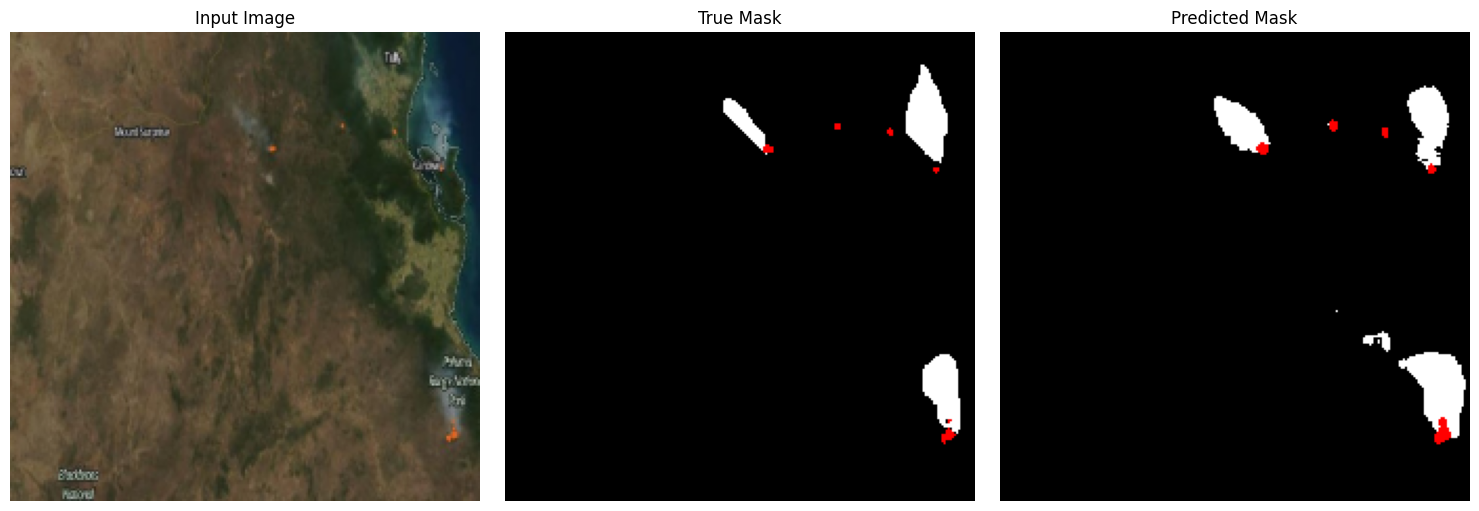

186


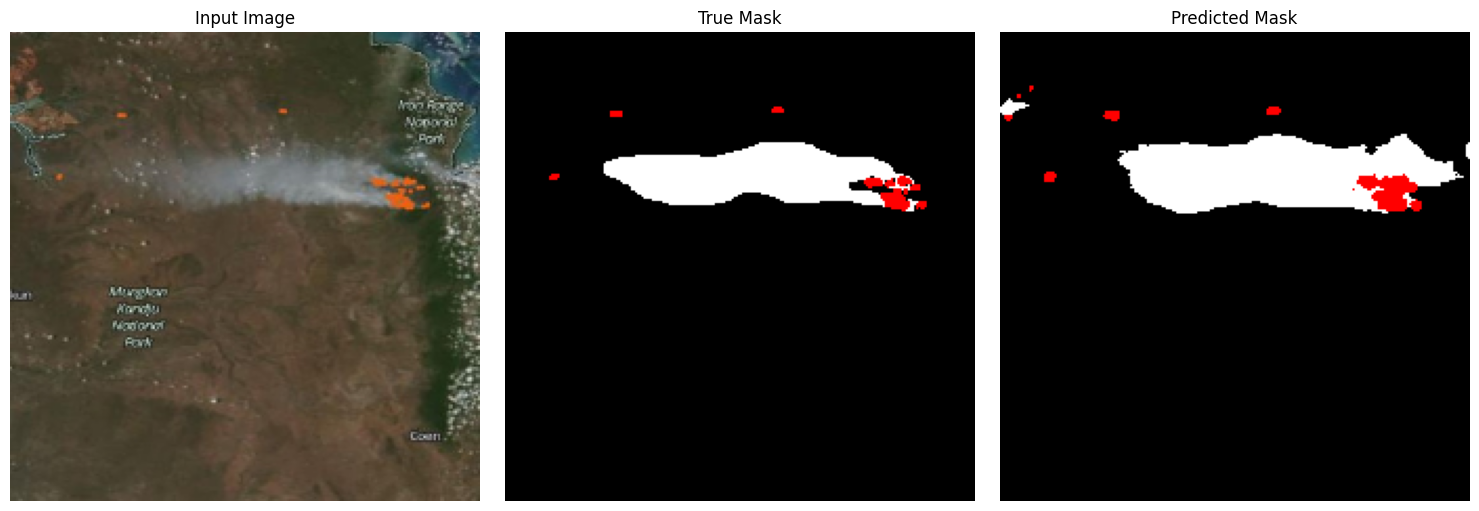

187


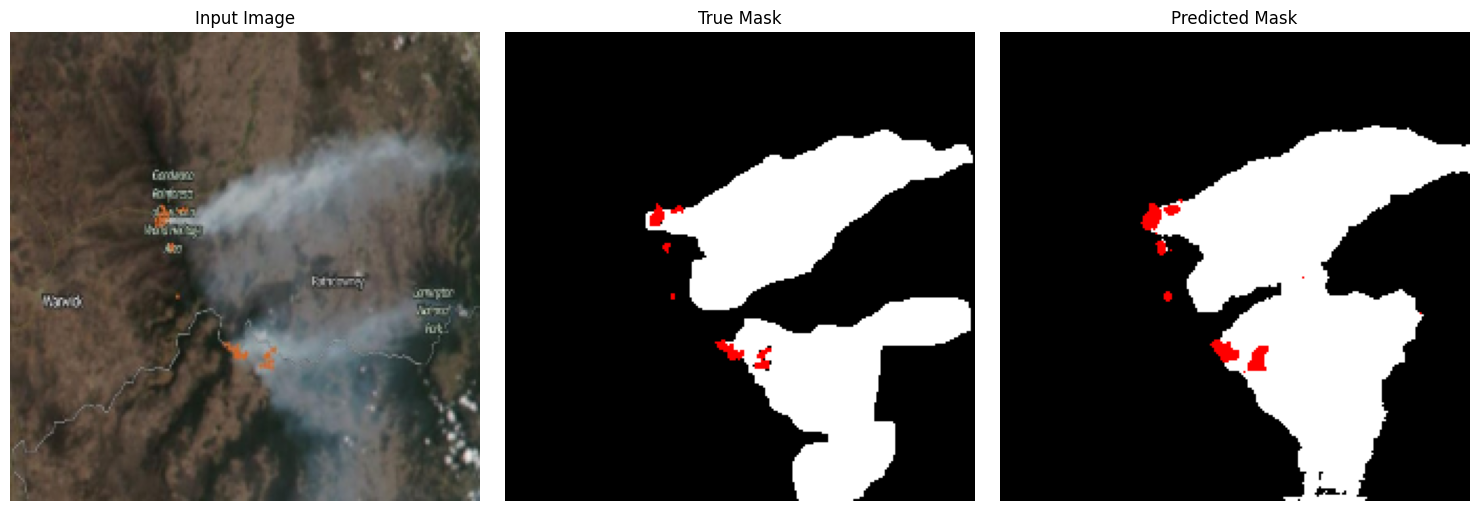

188


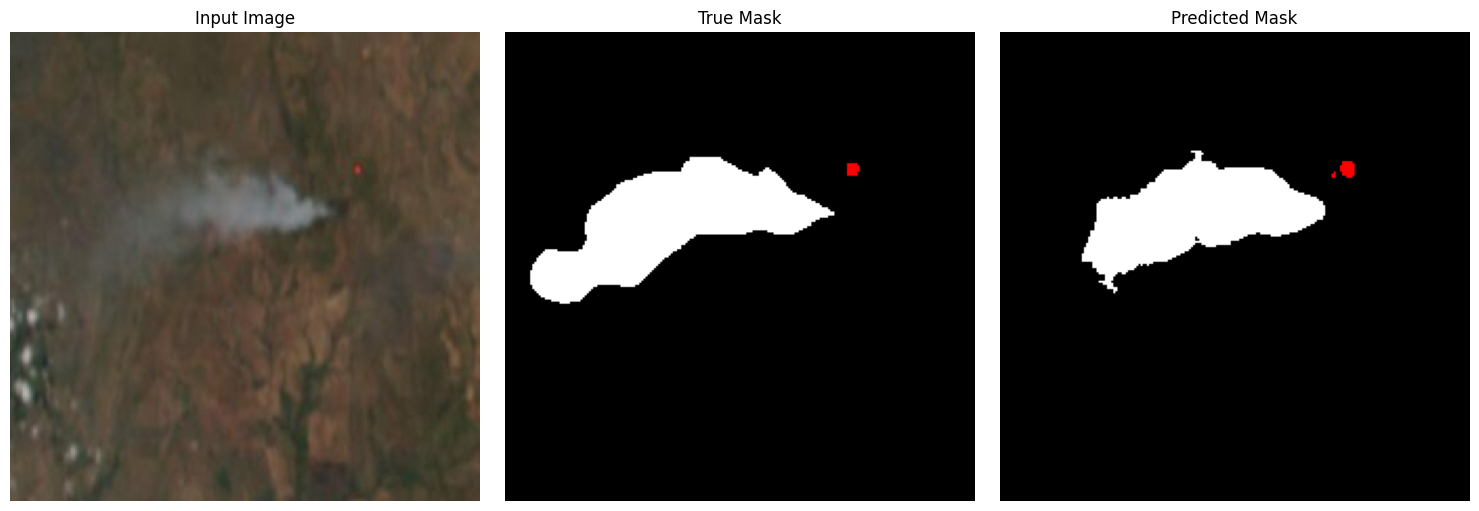

189


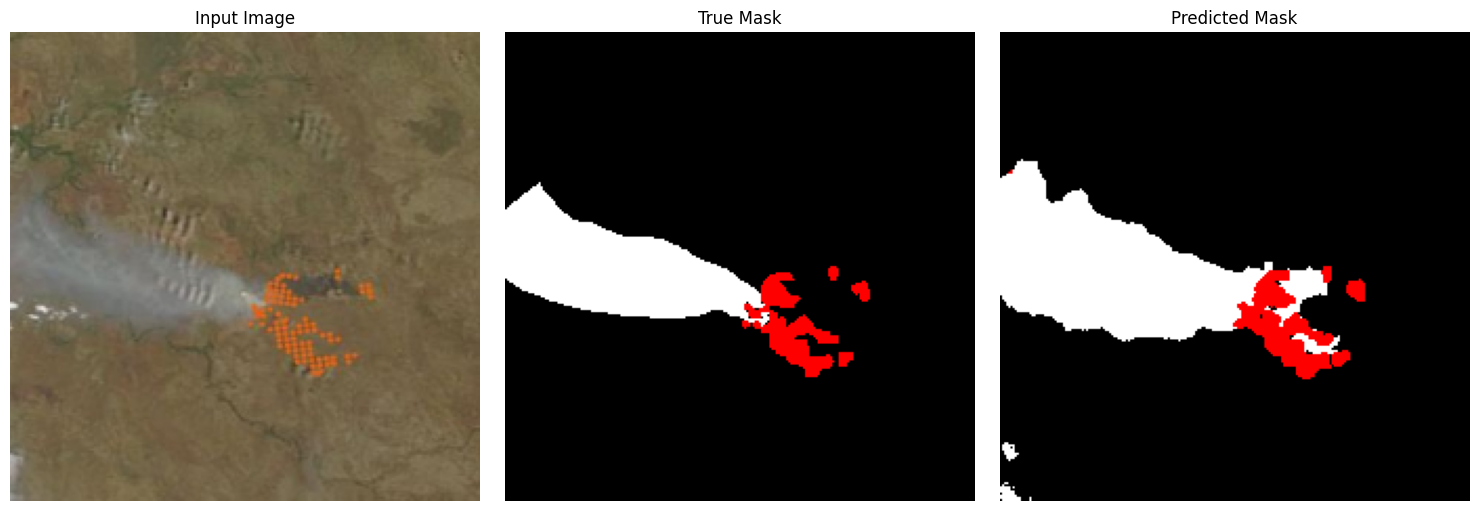

190


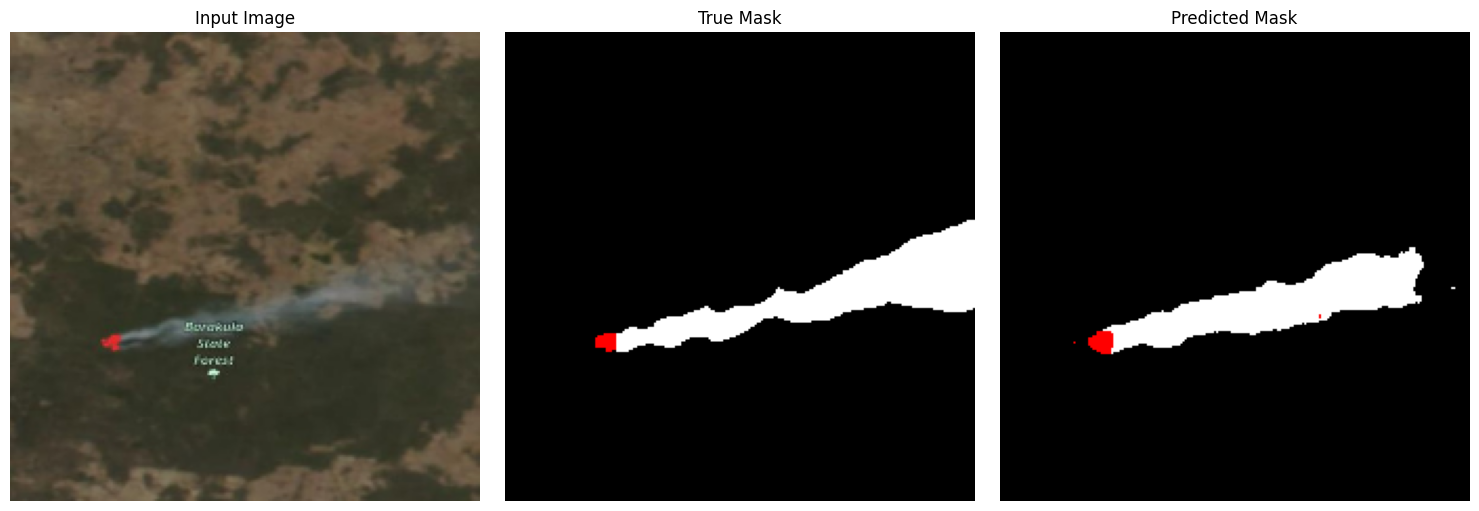

191


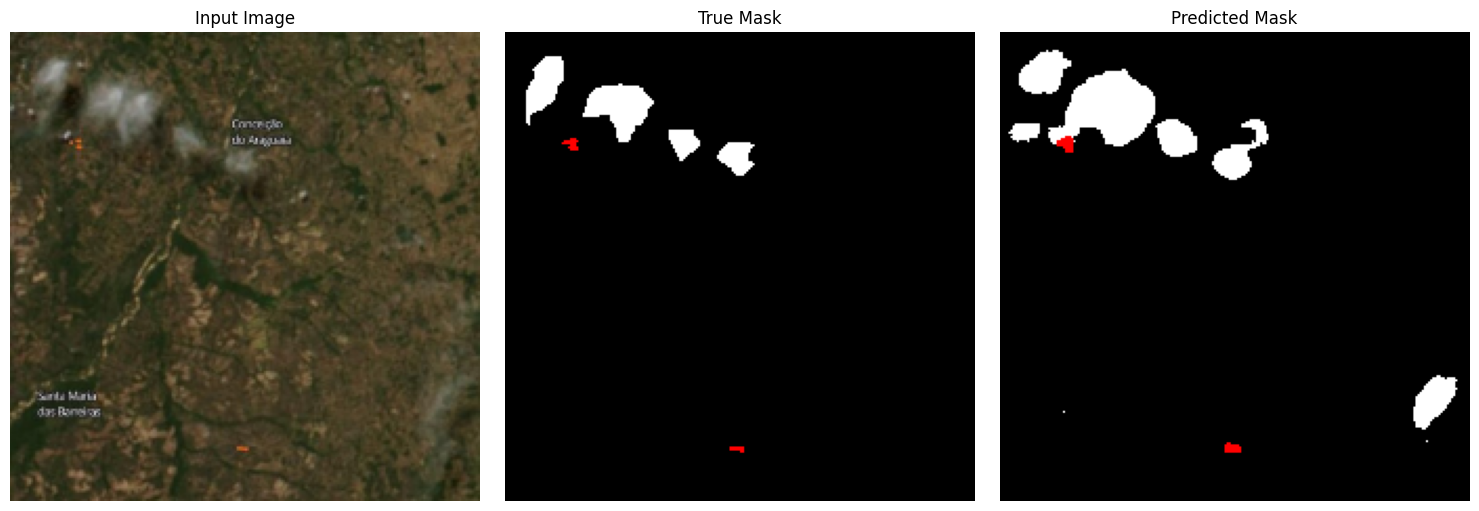

192


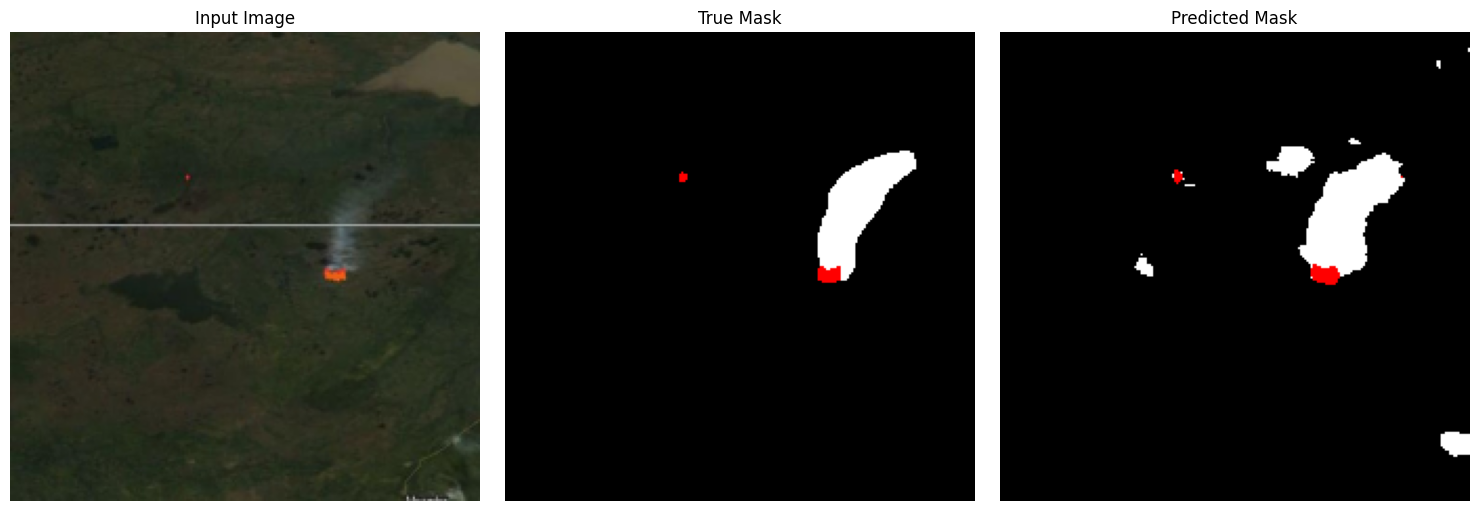

193


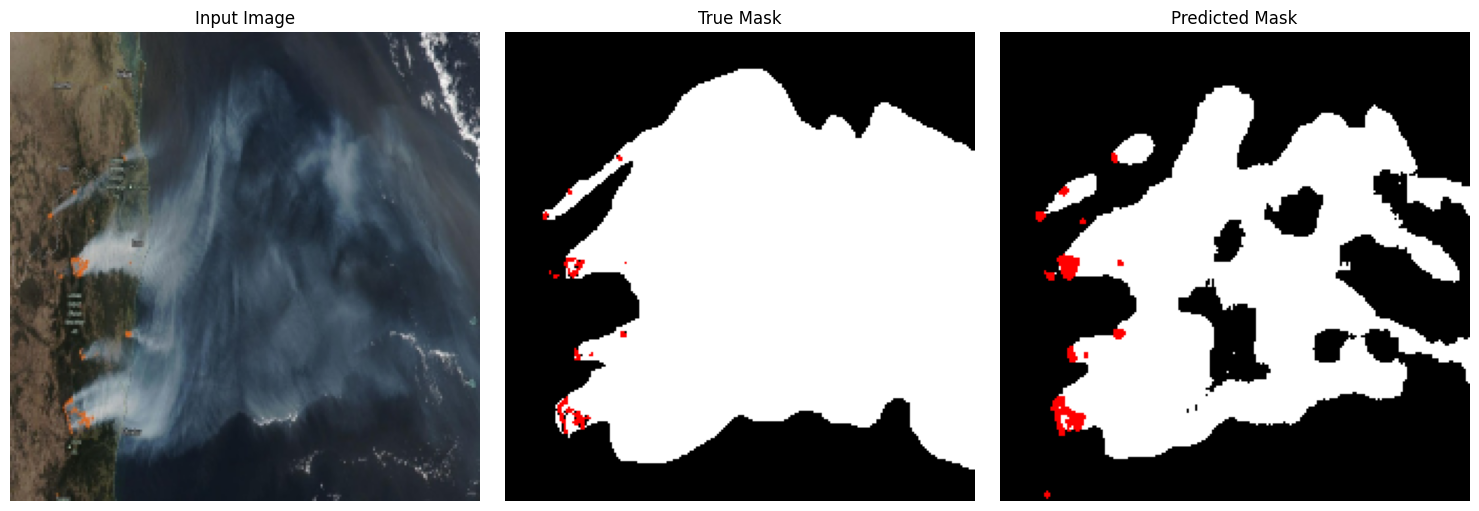

194


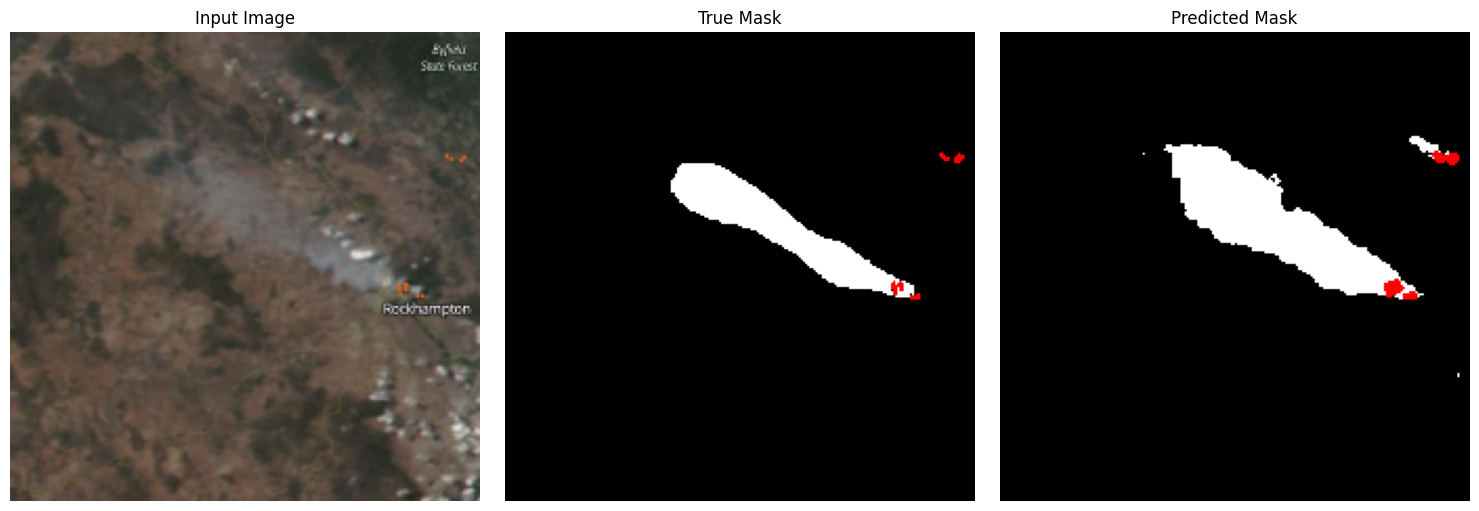

195


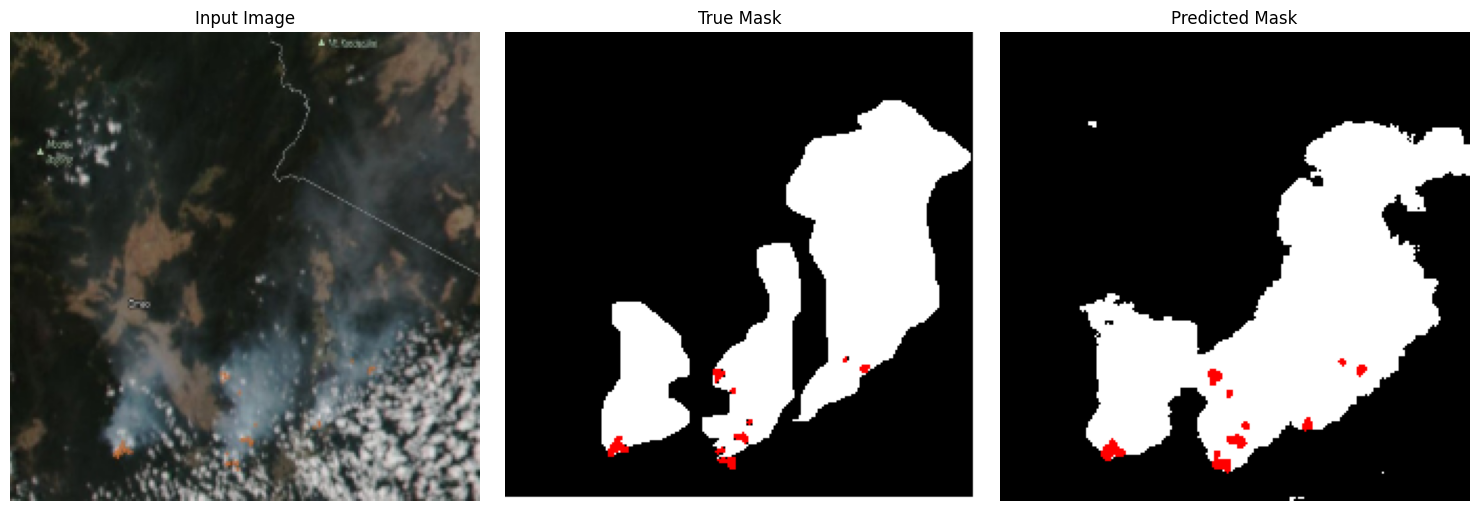

196


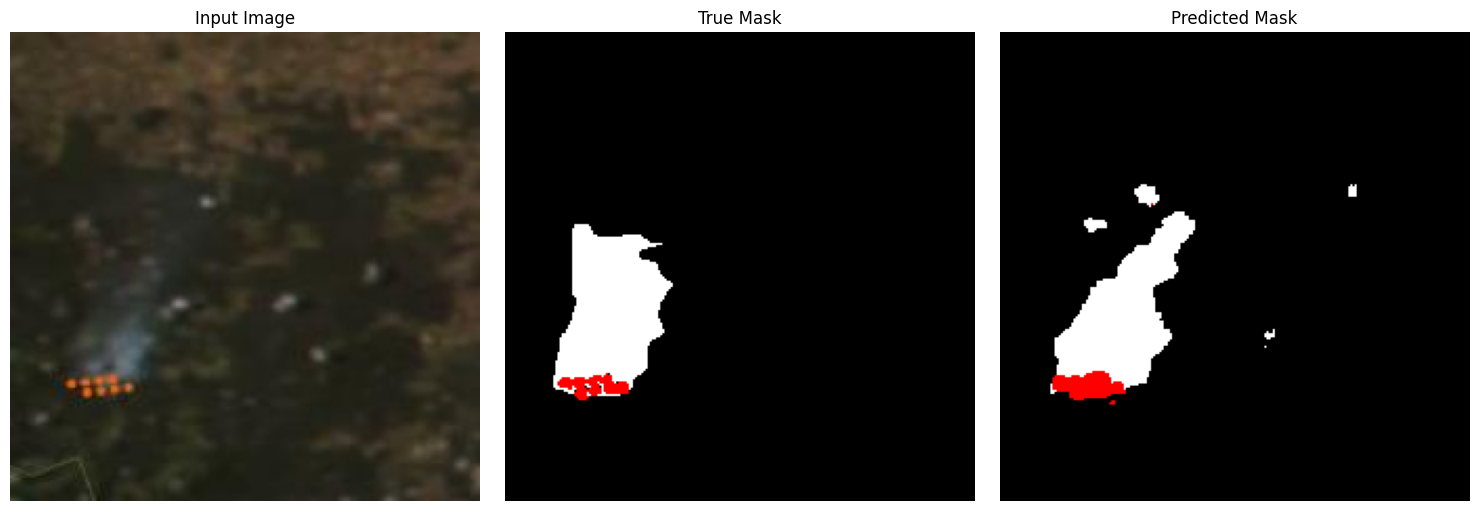

197


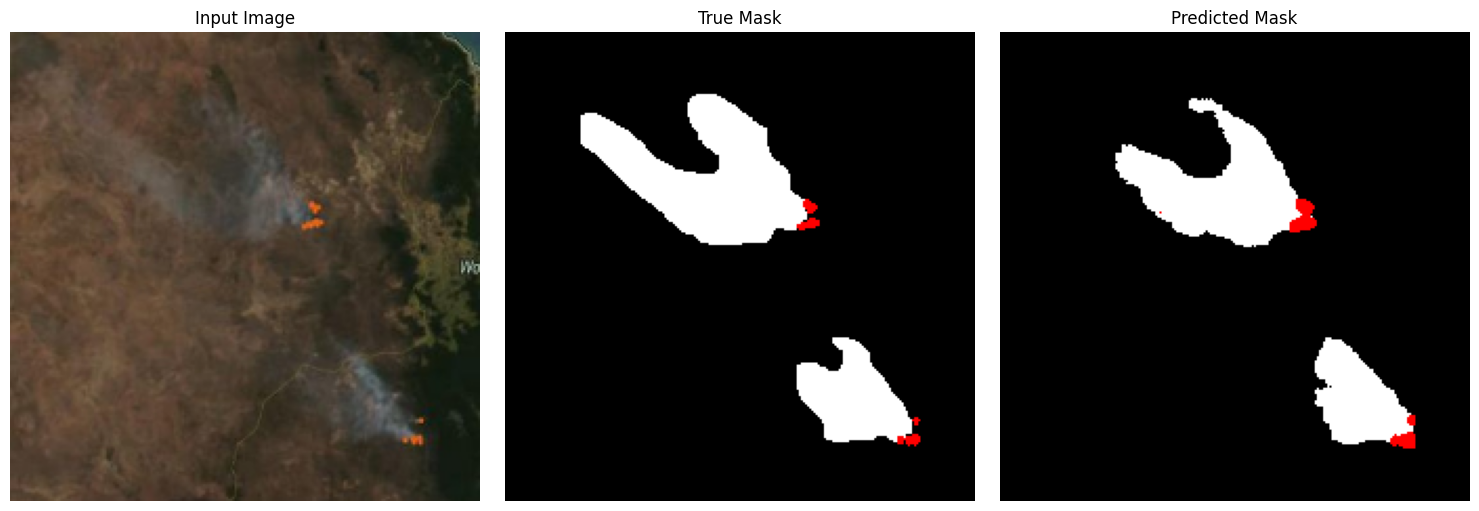

198


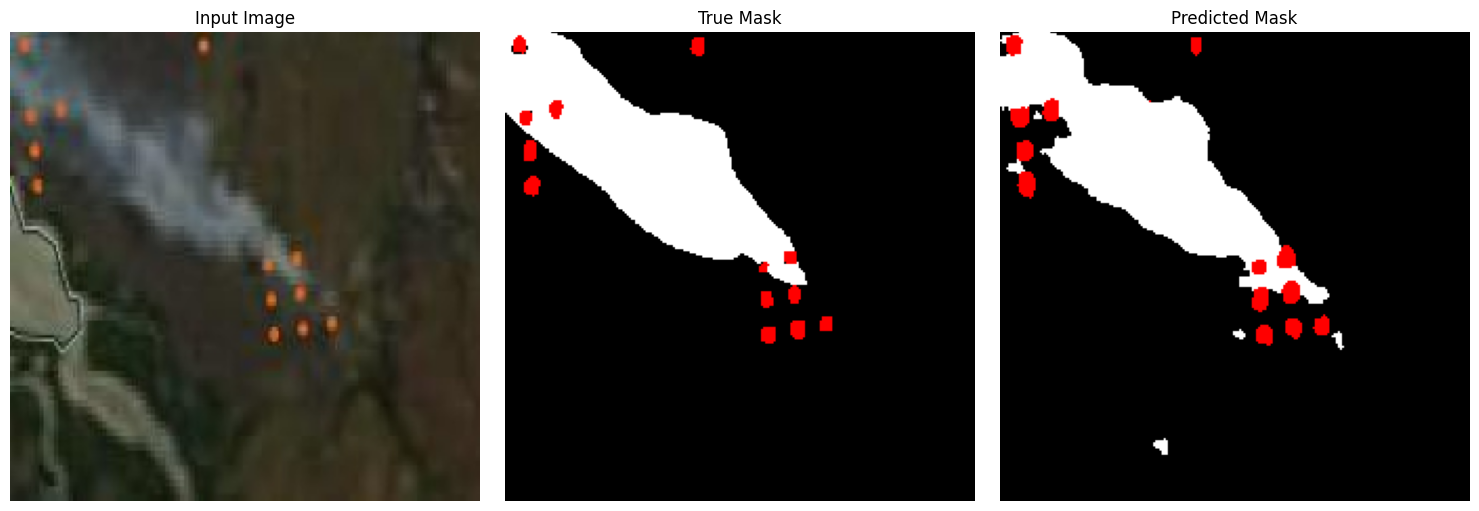

199


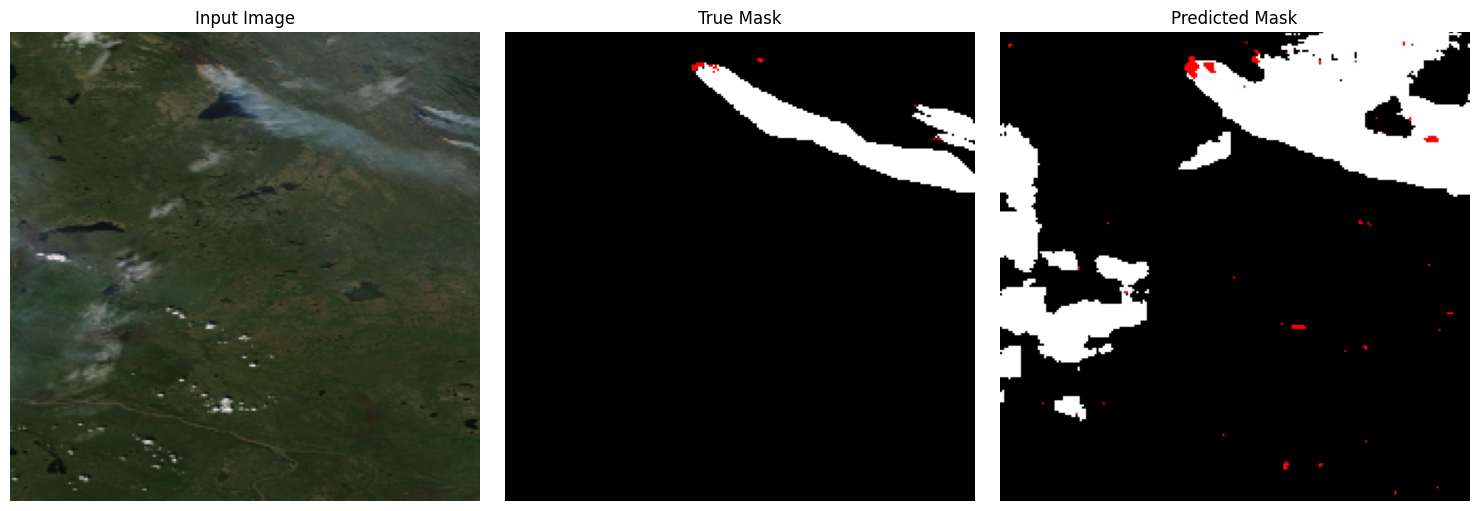

In [79]:
for i in range(180,200):
  print(i)
  plot_prediction(i)

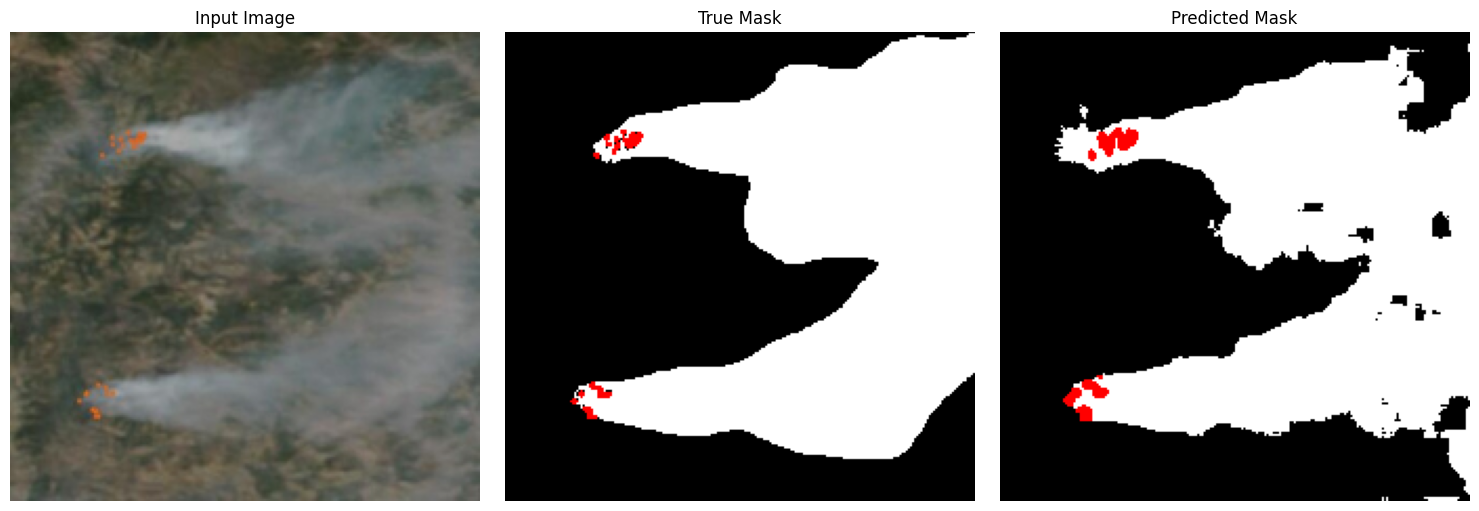

In [75]:
plot_prediction(87)

In [56]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test.flatten(), np.argmax(predictions, axis=-1).flatten())

print(f"Accuracy: {accuracy}")

Accuracy: 0.9354943236623008


In [ ]:
model.save('my_model.h5')  


In [ ]:
model.save_weights('model_weights.weights.h5')
